In [12]:
import numpy as np
import pandas as pd
import xgboost as xgb

import matplotlib.pyplot as plt
%matplotlib inline

import glob
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [13]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [11]:
# COCO データセットの関節名
# Human3.6M の関節名と統一 RAnkle -> RFoot
# Human3.6M に含まれない？　or モデルの学習に用いていない REye.LEye,REar,LEar, Bkg等 は除かれる
#  StackedHourglass モデルに比べて足りない点 : Head, Hip, Spine, Thorax（胸郭)
# そもそも Stacked Hourglass は何のデータから訓練したのか? COCO を用いているのであれば同じであるべき

# 役割としては  下記の対応が考えられる Hip は RHip, LHipの中間値を用いる考えも，
# COCO : Neck < - > SH : Throax 
# COCO : Nose < - > SH : Head  

#     POSE_COCO_BODY_PARTS {
#         {0,  "Nose"},
#         {1,  "Neck"},
#         {2,  "RShoulder"},
#         {3,  "RElbow"},
#         {4,  "RWrist"},
#         {5,  "LShoulder"},
#         {6,  "LElbow"},
#         {7,  "LWrist"},
#         {8,  "RHip"},
#         {9,  "RKnee"},
#         {10, "RAnkle"},
#         {11, "LHip"},
#         {12, "LKnee"},
#         {13, "LAnkle"},
#         {14, "REye"},
#         {15, "LEye"},
#         {16, "REar"},
#         {17, "LEar"},
#         {18, "Bkg"},
#     }

COCO_NAMES = ['']*19
COCO_NAMES[0] = 'Head'
COCO_NAMES[1] = 'Thorax'
COCO_NAMES[2] = 'RShoulder'
COCO_NAMES[3] = 'RElbow'
COCO_NAMES[4] = 'RWrist'
COCO_NAMES[5] = 'LShoulder'
COCO_NAMES[6] = 'LElbow'
COCO_NAMES[7] = 'LWrist'
COCO_NAMES[8] = 'RHip'
COCO_NAMES[9] = 'RKnee'
COCO_NAMES[10] = 'RFoot'
COCO_NAMES[11] = 'LHip'
COCO_NAMES[12] = 'LKnee'
COCO_NAMES[13] = 'LFoot'
COCO_NAMES[14] = 'Reye' 
COCO_NAMES[15] = 'LEye'
COCO_NAMES[16] = 'REar'
COCO_NAMES[17] = 'LEar'
COCO_NAMES[18] = 'Bkg'

In [8]:
base_dir = '/Users/tsuchiyashouto/Google ドライブ/先端人工知能論_Team05/openpose-work'

In [27]:
pict_dir = base_dir + "/pict_push-ups-from-side/2-1.COCO-pose/"
movi_dir = base_dir + "/movie_push-ups-from-side/2-1.COCO-pose/"

In [30]:
target = ['Head', 'Thorax', 'RShoulder', 'RElbow', 'RWrist', 'LShoulder', 'LElbow', 'LWrist']
dim_to_use_x    = np.where(np.array([name in target for name  in COCO_NAMES]))[0] * 3
dim_to_use_y    = dim_to_use_x+1
dim_to_use_p    = dim_to_use_x+2

dim_to_use = np.zeros(len(dim_to_use_x)*3,dtype=np.int32)
dim_to_use[0::3] = dim_to_use_x
dim_to_use[1::3] = dim_to_use_y
dim_to_use[2::3] = dim_to_use_p

In [85]:
df_mv =pd.read_csv(movi_dir + 'IMG_4937.csv', header=None)
nan_Idx = np.where(pd.isnull(df_mv[1]))[0]
not_nan_Idx = np.where(pd.isnull(df_mv[1])==False)[0]
whole_predict = np.zeros(df_mv.shape[0])

In [86]:
df_mv = df_mv.dropna()
df_mv[0] = df_mv[0].values.astype('float')

df_mv_upperbody = df_mv[dim_to_use]

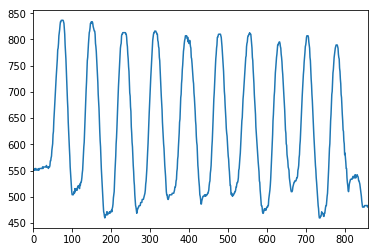

In [87]:
df_mv_upperbody[1].plot()

In [69]:
nan_Idx

array([ 21,  24,  26,  27,  29,  30,  36,  37,  38,  40,  41, 103, 106,
       111, 117, 120, 166, 171, 174, 177, 178, 179, 180, 182, 183, 184,
       185, 186, 187, 236, 240, 241, 242, 243, 245, 246, 247, 310, 313,
       320, 324])

In [77]:
df_mv.iloc[21,:]

0     IMG_4936.0022.jpg
1                   NaN
2                   NaN
3                   NaN
4                   NaN
5                   NaN
6                   NaN
7                   NaN
8                   NaN
9                   NaN
10                  NaN
11                  NaN
12                  NaN
13                  NaN
14                  NaN
15                  NaN
16                  NaN
17                  NaN
18                  NaN
19                  NaN
20                  NaN
21                  NaN
22                  NaN
23                  NaN
24                  NaN
25                  NaN
26                  NaN
27                  NaN
28                  NaN
29                  NaN
30                  NaN
31                  NaN
32                  NaN
33                  NaN
34                  NaN
35                  NaN
36                  NaN
37                  NaN
38                  NaN
39                  NaN
40                  NaN
41              

In [10]:
pict_up_file = ["IMG_{}.JPG".format(i) for i in range(4924, 4930)] # + 
               # ["IMG_{}.JPG".format(i) for i in range(4924, 4930)] # 後半は関節認識がうまくいってない
pict_down_file = ["IMG_{}.JPG".format(i) for i in range(4930, 4936)] # + 
               # ["IMG_{}.JPG".format(i) for i in range(4924, 4930)] # 後半は関節認識がうまくいってない
movi_base = "IMG_4937"
movi_file = movi_base + ".csv"

In [15]:
def sin(x, T=100):
    return np.sin(2.0 * np.pi * x / T)

# sin波にノイズを付与する
def toy_problem(T=100, ampl=0.05):
    x = np.arange(0, 2 * T + 1)
    noise = ampl * np.random.uniform(low=-1.0, high=1.0, size=len(x))
    return sin(x) + noise

f = toy_problem()

In [16]:
def make_dataset(low_data, n_prev=100):

    data, target = [], []
    maxlen = 25

    for i in range(len(low_data)-maxlen):
        data.append(low_data[i:i + maxlen])
        target.append(low_data[i + maxlen])

    re_data = np.array(data).reshape(len(data), maxlen, 1)
    re_target = np.array(target).reshape(len(data), 1)

    return re_data, re_target


#g -> 学習データ，h -> 学習ラベル
g, h = make_dataset(f)

In [89]:
h.shape

(176, 1)

In [17]:
# モデル構築

# 1つの学習データのStep数(今回は25)
length_of_sequence = g.shape[1] 
in_out_neurons = 1
n_hidden = 300

model = Sequential()
model.add(LSTM(n_hidden, batch_input_shape=(None, length_of_sequence, in_out_neurons), return_sequences=False))
model.add(Dense(in_out_neurons))
model.add(Activation("linear"))
optimizer = Adam(lr=0.001)
model.compile(loss="mean_squared_error", optimizer=optimizer)

In [18]:
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)
model.fit(g, h,
          batch_size=300,
          epochs=100,
          validation_split=0.1,
          callbacks=[early_stopping]
          )

Train on 158 samples, validate on 18 samples
Epoch 1/100
158/158 [==============================] - 1s - loss: 0.6037 - val_loss: 0.1917
Epoch 2/100
158/158 [==============================] - 0s - loss: 0.4128 - val_loss: 0.0779
Epoch 3/100
158/158 [==============================] - 0s - loss: 0.2646 - val_loss: 0.0318
Epoch 4/100
158/158 [==============================] - 0s - loss: 0.1551 - val_loss: 0.1019
Epoch 5/100
158/158 [==============================] - 0s - loss: 0.1044 - val_loss: 0.2379
Epoch 6/100
158/158 [==============================] - 0s - loss: 0.1134 - val_loss: 0.1990
Epoch 7/100
158/158 [==============================] - 0s - loss: 0.0878 - val_loss: 0.1076
Epoch 8/100
158/158 [==============================] - 0s - loss: 0.0525 - val_loss: 0.0491
Epoch 9/100
158/158 [==============================] - 0s - loss: 0.0375 - val_loss: 0.0234
Epoch 10/100
158/158 [==============================] - 0s - loss: 0.0365 - val_loss: 0.0142
Epoch 11/100
158/158 [============

In [19]:
# 予測
predicted = model.predict(g)

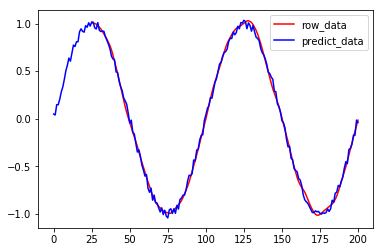

In [20]:
plt.figure()
plt.plot(range(25,len(predicted)+25),predicted, color="r", label="row_data")
plt.plot(range(0, len(f)), f, color="b", label="predict_data")
plt.legend()
plt.show()

In [23]:
len(f)-25

176

In [26]:
g.shape

(176, 25, 1)